In [37]:
%matplotlib inline

## Load data

In [2]:
import json
import pandas as pd
import os
from sklearn.model_selection import train_test_split

from sklearn.utils import class_weight
import numpy as np

def info_to_df(paths: list, x_col='filename', y_col='class') -> pd.DataFrame:
    info_ds = pd.DataFrame(paths, columns=[x_col])
    info_ds[y_col] = info_ds[x_col].apply(lambda x: x.split('/')[0])

    return info_ds.sample(frac=1)

In [3]:
data_dir = '/home/projects/flickr90k/'

with open(os.path.join(data_dir,'train_test_split.json'), 'r') as f:
    split_info = json.load(f)

train_val_df = info_to_df(split_info['train'])
test_df = info_to_df(split_info['test'])

train_df, val_df = train_test_split(train_val_df,
                                    test_size=0.10,
                                    stratify=train_val_df['class'],
                                    random_state=42)

print("Training data size: {} \nValidation data size: {} \nTest data size: {}" \
      .format(len(train_df), len(val_df), len(test_df)))

Training data size: 76500 
Validation data size: 8500 
Test data size: 5000


In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
unique_classes = list(np.unique(train_df['class'].values))
le.fit(unique_classes)

print(list(le.classes_))
print(le.transform(unique_classes))

['bird', 'boat', 'cat', 'dog', 'flower', 'frog', 'jumbojet', 'mushroom', 'sportscar', 'tree']
[0 1 2 3 4 5 6 7 8 9]


In [5]:
train_df['class_enc'] = le.transform(train_df['class'])
val_df['class_enc'] = le.transform(val_df['class'])
test_df['class_enc'] = le.transform(test_df['class'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
test_df.head()

,filename,class,class_enc
448,cat/17939.jpg,cat,2
1665,boat/04650.jpg,boat,1
2130,sportscar/00427.jpg,sportscar,8
4101,tree/4907.jpg,tree,9
660,frog/00535.jpg,frog,5


In [7]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train_df['class'].values),
                                                  train_df['class'].values)
print(class_weights)
class_weights = dict(enumerate(class_weights))

class_weights

[0.89473684 0.89473684 0.43589744 0.89473684 1.88888889 0.89473684
 1.88888889 1.88888889 0.89473684 1.88888889]


{0: 0.8947368421052632,
 1: 0.8947368421052632,
 2: 0.4358974358974359,
 3: 0.8947368421052632,
 4: 1.8888888888888888,
 5: 0.8947368421052632,
 6: 1.8888888888888888,
 7: 1.8888888888888888,
 8: 0.8947368421052632,
 9: 1.8888888888888888}

## Prepare dataset class, setup network and training data

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import time
import os
import argparse
from PIL import Image
from torch.utils.data import Dataset, DataLoader      
from torchvision.transforms import Resize, ToTensor, Normalize, Compose
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
import torchvision
import torchvision.transforms as transforms

import torchvision.models as models
import torch.nn as nn


input_shape = 299
batch_size = 64
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
scale = 360
input_shape = 299 
use_parallel = True
num_workers = 0

use_gpu = True
epochs = 100

In [40]:
class Flickr90kDataset(Dataset):
    """Recrutment Task dataset."""

    def __init__(self, dataframe, data_dir, transform=None):
        """
        Args:
            dataframe (): ...
            image_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dataframe = dataframe
        self.image_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir,
                                self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.dataframe.iloc[idx, 2]
    
        if self.transform:
            image = self.transform(image)
        
        return image, label


data_transforms = {
        'train': transforms.Compose([
        transforms.Resize(scale),
        transforms.RandomResizedCrop(input_shape),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=90),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)]),
        'test': transforms.Compose([
        transforms.Resize(scale),
        transforms.CenterCrop(input_shape),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)]),}


train_dataset = Flickr90kDataset(train_df,
                                 data_dir,
                                 data_transforms['train'])

val_dataset = Flickr90kDataset(val_df,
                               data_dir,
                               data_transforms['train'])




In [41]:
image_datasets = {'train': train_dataset , 'test': val_dataset}
dataloaders = {'train': trainloader , 'test': valloader}
dataset_sizes = {'train': len(train_dataset) , 'test': len(val_dataset)}

In [42]:

    
for i in range(5):
    
    image, label = next(iter(dataloaders['train']))
    print(label)


tensor([2, 8, 7, 4, 2, 5, 2, 7, 7, 4, 7, 1, 4, 2, 2, 2, 8, 8, 1, 0, 0, 2, 1, 5,
        1, 2, 3, 1, 6, 2, 2, 2])
tensor([8, 9, 2, 2, 0, 3, 5, 2, 1, 2, 3, 6, 3, 5, 7, 7, 3, 0, 9, 5, 0, 2, 2, 2,
        6, 2, 5, 2, 2, 1, 7, 2])
tensor([5, 0, 5, 3, 7, 2, 2, 2, 5, 1, 5, 9, 6, 5, 2, 2, 2, 0, 6, 4, 0, 5, 7, 6,
        5, 2, 2, 2, 5, 7, 7, 8])
tensor([3, 0, 0, 1, 9, 3, 6, 4, 8, 2, 0, 1, 8, 4, 2, 1, 5, 2, 5, 2, 1, 7, 0, 1,
        7, 4, 3, 2, 6, 2, 5, 8])
tensor([8, 6, 5, 2, 8, 2, 5, 8, 2, 5, 9, 2, 3, 1, 0, 2, 2, 2, 5, 2, 3, 1, 3, 8,
        2, 2, 1, 1, 1, 1, 2, 8])


In [43]:
image = Image.open('/home/projects/flickr90k/boat/08622.jpg').convert('RGB')
image.show()
plt.show()

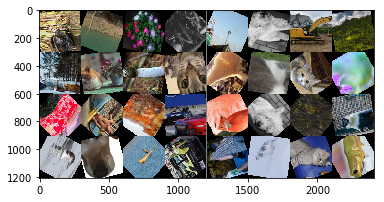

['bird' 'boat' 'cat' 'mushroom' 'boat' 'dog' 'cat' 'frog' 'boat' 'cat'
 'mushroom' 'cat' 'mushroom' 'cat' 'cat' 'flower' 'dog' 'boat' 'mushroom'
 'sportscar' 'cat' 'dog' 'bird' 'frog' 'bird' 'cat' 'boat' 'sportscar'
 'boat' 'bird' 'cat' 'frog']


In [44]:


# get some random training images
dataiter = iter(trainloader)
imgs, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(imgs))
print(le.inverse_transform(labels))

### Prepare convolutional network and freeze layers

In [18]:
n_class = len(class_weights)
freeze_layers = True

## Load the model 
model_conv = torchvision.models.inception_v3(pretrained='imagenet')

## Lets freeze the first few layers. This is done in two stages 
# Stage-1 Freezing all the layers 
if freeze_layers:
    for i, param in model_conv.named_parameters():
        param.requires_grad = False

# Since imagenet as 1000 classes , We need to change our last layer according to the number of classes we have,
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, n_class)

# Stage-2 , Freeze all the layers till "Conv2d_4a_3*3"
ct = []
for name, child in model_conv.named_children():
    if "Conv2d_4a_3x3" in ct:
        for params in child.parameters():
            params.requires_grad = True
    ct.append(name)

In [39]:
model_conv 


DataParallel(
  (module): DataParallel(
    (module): DataParallel(
      (module): DataParallel(
        (module): DataParallel(
          (module): Inception3(
            (Conv2d_1a_3x3): BasicConv2d(
              (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
              (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            )
            (Conv2d_2a_3x3): BasicConv2d(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            )
            (Conv2d_2b_3x3): BasicConv2d(
              (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            )
            (Conv2d_3b_1x1): BasicConv2d(
              (conv): Conv2d(64, 80, kernel_size=(1, 1), stri

# Train the model

In [45]:
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models

import numpy as np

import os
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import pandas as pd

#from pytorch_utils import train_model, evaluate_model, evaluate_model_test

In [46]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms


def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, use_gpu, num_epochs=25, alpha = 0.1):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in tqdm(dataloaders[phase]):
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                if type(outputs) == tuple:
                    outputs, _ = outputs
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [47]:
lr = 0.1
step_size = 100

use_gpu = True
epochs = 100

step_size=7
lr=0.001

if use_parallel:
    print("[Using all the available GPUs]")
    model_conv = nn.DataParallel(model_conv, device_ids=[0])

print("[Using CrossEntropyLoss...]")
criterion = nn.CrossEntropyLoss()

print("[Using small learning rate with momentum...]")
optimizer_conv = optim.SGD(list(filter(lambda p: p.requires_grad, model_conv.parameters())), lr=lr, momentum=0.9)

print("[Creating Learning rate scheduler...]")
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=step_size, gamma=0.1)

print("[Training the model begun ....]")
model_ft = train_model(model_conv, dataloaders, dataset_sizes, criterion, optimizer_conv, exp_lr_scheduler, use_gpu, num_epochs=epochs)






  0%|          | 0/2391 [00:00<?, ?it/s]

[Using all the available GPUs]
[Using CrossEntropyLoss...]
[Using small learning rate with momentum...]
[Creating Learning rate scheduler...]
[Training the model begun ....]
Epoch 0/99
----------







  0%|          | 1/2391 [00:01<57:28,  1.44s/it]




  0%|          | 2/2391 [00:02<55:49,  1.40s/it]




  0%|          | 3/2391 [00:04<54:02,  1.36s/it]




  0%|          | 4/2391 [00:05<53:00,  1.33s/it]




  0%|          | 5/2391 [00:06<52:32,  1.32s/it]

KeyboardInterrupt: 

# Evaluate on the test set

In [ ]:


def evaluate_model(mode, model_conv, input_data_loc, input_shape, use_gpu, name):
    """A function which evaluates the model and outputs the csv of predictions of validation and train.
    mode:
    model_conv:
    input_data_loc:
    input_shape:
    use_gpu:
    Output:
    1) Prints score of train and validation (Write it to a log file)
    """
    print("[Evaluating the data in {}]".format(mode))
    data_loc = os.path.join(input_data_loc, mode)

    print("[Building dataloaders]")
    dataloaders, image_datasets = data_loader_predict(data_loc, input_shape, name)
    class_to_idx = image_datasets.class_to_idx
    imgs = [i[0] for i in image_datasets.imgs]
    print("total number of {} images: {}".format(mode, len(imgs)))
    original, predicted, probs = [], [], []
    for img, label in dataloaders:
        if use_gpu:
            inputs = Variable(img.cuda())
        else:
            inputs = Variable(img)
        bs, ncrops, c, h, w = inputs.data.size()
        output = model_conv(inputs.view(-1, c, h, w)) # fuse batch size and ncrops
        if type(output) == tuple:
            output, _ = output
        else:
            output = output
        outputs = torch.stack([nn.Softmax(dim=0)(i) for i in output])
        outputs = outputs.mean(0)
        _, preds = torch.max(outputs, 0)
        probs.append(outputs.data.cpu().numpy())
        original.extend(label.numpy())
        predicted.extend(preds.data.cpu().numpy())
    print("Accuracy_score {} : {} ".format(mode,  accuracy_score(original, predicted)))
    frame = pd.DataFrame(probs)
    frame.columns = ["class_{}".format(i) for i in frame.columns]
    frame["img_loc"] = imgs
    frame["original"] = original
    frame["predicted"] = predicted
    return frame, class_to_idx


def evaluate_model_test(mode, model_conv, test_input_data_loc, input_shape, use_gpu, name):
    dataloaders, image_datasets = data_loader_predict(test_input_data_loc, input_shape, name)
    imgs =[i[0] for i in image_datasets.imgs]
    print("total number of {} images: {}".format(mode, len(imgs)))
    predicted, probs = [], []
    for img, label in dataloaders:
        if use_gpu:
            inputs = Variable(img.cuda())
        else:
            inputs = Variable(img)
        bs, ncrops, c, h, w = inputs.data.size()
        output = model_conv(inputs.view(-1, c, h, w)) # fuse batch size and ncrops
        if type(output) == tuple:
            output, _ = output
        else:
            output = output
        outputs = torch.stack([nn.Softmax(dim=0)(i) for i in output])
        outputs = outputs.mean(0)
        _, preds = torch.max(outputs, 0)
        probs.append(outputs.data.cpu().numpy())
        predicted.extend(preds.data.cpu().numpy())
    frame = pd.DataFrame(probs)
    frame.columns = ["class_{}".format(i) for i in frame.columns]
    frame["img_loc"] = imgs
    frame["predicted"] = predicted
    return frame

In [ ]:
test_dataset = Flickr90kDataset(test_df,
                                image_dir,
                                data_transforms['val'])

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                         shuffle=False, num_workers=2)